In [2]:
import pandas as pd
import numpy as np

In [160]:
sigma = 0.5
mean_a = [-1,-1]
cov_a = sigma * np.array( [[2,0.5],[0.5,1]])
mean_b = [1,-1]
cov_b = sigma * np.array([[1, -0.5],[-0.5,2]])
mean_c = [0,1]
cov_c = sigma * np.array( [[1,0],[0,2]])
means = [[-1,-1], [1,-1], [0,1]]

In [15]:
np.random.seed(0)
X_a = np.random.multivariate_normal(mean_a, cov_a, 100)
X_b = np.random.multivariate_normal(mean_b, cov_b, 100)
X_c = np.random.multivariate_normal(mean_c, cov_c, 100)
X = np.vstack((X_a, X_b, X_c))
Y = [0]*100+[1]*100+[2]*100

In [29]:
init = np.repeat(np.mean(X, axis=0).reshape(1,-1), 3, axis=0)+np.random.random((3, X.shape[1]))

In [194]:
class KMeans:
    def __init__(self, n_clusters = 3) -> None:
        self.n_clusters = 3
    
    def fit(self, X):
        optimal_centers = []
        optimal_obj = float('inf')
        for i in range(5):
            #init
            self.centers = np.repeat(np.mean(X, axis=0).reshape(1,-1), self.n_clusters, axis=0)+np.random.random((self.n_clusters, X.shape[1]))
            new_obj = float('inf')
            old_obj = float('inf')
            init = False
            while(new_obj < old_obj or init == False):
                init = True
                clusters = self.pred(X)
                #calc objective
                old_obj = new_obj
                new_obj = 0
                new_centers = []
                for i in range(self.n_clusters):
                    X_c = X[clusters == i]
                    X_cen = np.mean(X_c, axis=0)
                    new_centers.append(X_cen)
                    new_obj = new_obj + np.sum(np.linalg.norm(X_c - X_cen, axis=1)**2)
                new_centers = np.array(new_centers)
                self.centers = new_centers
                # print(old_obj, new_obj)
            if new_obj < optimal_obj:
                optimal_centers = new_centers
                optimal_obj = new_obj
        self.centers = optimal_centers
        self.optimal_obj = optimal_obj
        
    
    def pred(self, X):
        clusters = []
        for i in X:
            min_dis = float('inf')
            cluster = 0
            for j in range(len(self.centers)):
                dis = np.linalg.norm(i-self.centers[j])
                if dis < min_dis:
                    min_dis = dis
                    cluster = j
            clusters.append(cluster)
        clusters = np.array(clusters)
        return clusters



In [188]:
from scipy.stats import multivariate_normal
class GMM:
    def __init__(self, n_clusters = 3) -> None:
        self.n_clusters = n_clusters
    
    def fit(self, X):
        optimal_log_like = float('inf')
        optimal_mean = []
        optimal_cov = []
        optimal_phi = []
        for i in range(5): #fit multiple times
            #init
            self.mean = np.repeat(np.mean(X, axis=0).reshape(1,-1), self.n_clusters, axis=0)+np.random.random((self.n_clusters, X.shape[1]))
            self.cov = np.array([np.identity(X.shape[1]) for i in range(self.n_clusters)])
            self.phi = np.ones(self.n_clusters)/self.n_clusters #same probability for each cluster

            tolerance = 1e-3
            prev_log_like = float('inf')
            log_like = float('inf')
            
            init = False
            W = np.zeros((len(X), self.n_clusters))
            while(prev_log_like -log_like > tolerance or init == False):
                init = True
                prev_log_like = log_like

                #E step
                for i in range(self.n_clusters):
                    W[:,i] = multivariate_normal.pdf(X, self.mean[i], self.cov[i])
                W = np.multiply(W, self.phi)
                W = np.divide(W, np.sum(W, axis=1).reshape(-1,1))
                
                #M step
                self.phi = np.mean(W, axis=0)
                
                for i in range(self.n_clusters):
                    mean_temp = np.multiply(W[:, i].reshape(-1,1), X)
                    self.mean[i] = np.sum(mean_temp, axis=0)/np.sum(W[:, i])

                for i in range(self.n_clusters):
                    cov_temp = np.zeros_like(self.cov[0])
                    for j in range(len(X)):
                        cov_temp = cov_temp + W[j, i]* ((X[j]-self.mean[i]).reshape(-1,1) @ (X[j]-self.mean[i]).reshape(1,-1))
                    self.cov[i] = cov_temp/np.sum(W[:, i])
                # print(self.mean)
                #log likelihood
                pdfs = np.zeros((len(X),self.n_clusters))
                for i in range(self.n_clusters):
                    pdfs[:,i] = multivariate_normal.pdf(X, self.mean[i], self.cov[i])
                pdfs = np.multiply(pdfs, self.phi)
                log_like = np.sum(-np.log(np.sum(pdfs, axis=1)))
                # print(prev_log_like, log_like)
            if log_like < optimal_log_like:
                optimal_log_like = log_like
                optimal_mean = self.mean
                optimal_cov = self.cov
                optimal_phi = self.phi
        self.mean = optimal_mean
        self.cov = optimal_cov
        self.phi = optimal_phi
        self.optimal_log_like = optimal_log_like
            

    def pred(self, X):
        pdfs = np.zeros((len(X),self.n_clusters))
        for i in range(self.n_clusters):
            pdfs[:,i] = multivariate_normal.pdf(X, self.mean[i], self.cov[i])
        pos = np.multiply(pdfs, self.phi)
        return np.argmax(pos, axis=1)

In [190]:
def map_clusters(true_center, pred_center, pred):
    mapping = []
    for i in range(len(pred_center)):
        mapping.append(np.argmin(np.linalg.norm(true_center - pred_center[i], axis = 1)))
    # print(mapping)
    for i in range(len(pred)):
        pred[i] = mapping[pred[i]]
    return pred

In [192]:
from sklearn.metrics import accuracy_score
sigma_list = [0.5,1,2,4,8]
gmm = GMM(n_clusters=3)
for sigma in sigma_list:
    mean_a = [-1,-1]
    cov_a = sigma * np.array( [[2,0.5],[0.5,1]])
    mean_b = [1,-1]
    cov_b = sigma * np.array([[1, -0.5],[-0.5,2]])
    mean_c = [0,1]
    cov_c = sigma * np.array( [[1,0],[0,2]])
    means = [[-1,-1], [1,-1], [0,1]]
    X_a = np.random.multivariate_normal(mean_a, cov_a, 100)
    X_b = np.random.multivariate_normal(mean_b, cov_b, 100)
    X_c = np.random.multivariate_normal(mean_c, cov_c, 100)
    X = np.vstack((X_a, X_b, X_c))
    Y = [0]*100+[1]*100+[2]*100
    gmm.fit(X)
    pred = map_clusters(means, gmm.mean,gmm.pred(X))
    print(gmm.optimal_log_like, accuracy_score(pred, Y))

932.16029557148 0.8533333333333334
1044.2862610830769 0.5633333333333334
1214.0393677626184 0.57
1399.7109701606278 0.5133333333333333
1588.8223962122738 0.42


In [195]:
sigma_list = [0.5,1,2,4,8]
km = KMeans(n_clusters=3)
for sigma in sigma_list:
    mean_a = [-1,-1]
    cov_a = sigma * np.array( [[2,0.5],[0.5,1]])
    mean_b = [1,-1]
    cov_b = sigma * np.array([[1, -0.5],[-0.5,2]])
    mean_c = [0,1]
    cov_c = sigma * np.array( [[1,0],[0,2]])
    means = [[-1,-1], [1,-1], [0,1]]
    X_a = np.random.multivariate_normal(mean_a, cov_a, 100)
    X_b = np.random.multivariate_normal(mean_b, cov_b, 100)
    X_c = np.random.multivariate_normal(mean_c, cov_c, 100)
    X = np.vstack((X_a, X_b, X_c))
    Y = [0]*100+[1]*100+[2]*100
    km.fit(X)
    pred = map_clusters(means, km.centers, km.pred(X))
    print(km.optimal_obj, accuracy_score(pred, Y))

297.7830403834531 0.82
492.47899535743954 0.74
901.1257306844277 0.5733333333333334
1687.5288950474935 0.5333333333333333
3176.810482983754 0.5266666666666666


In [186]:
gmm = GMM(n_clusters=3)
gmm.fit(X)

<Axes: xlabel='0', ylabel='1'>

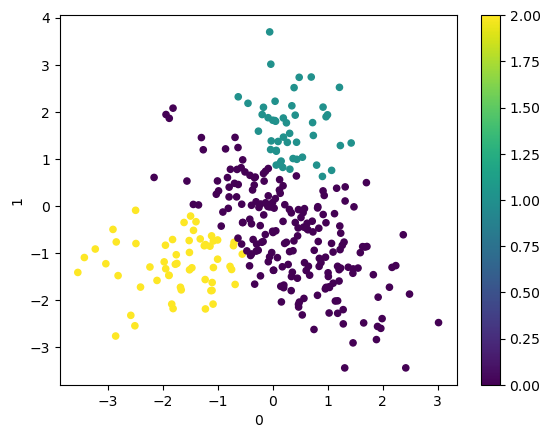

In [187]:
df = pd.DataFrame(X)
df['cluster'] = gmm.pred(X)
df.plot.scatter(x = 0, y = 1, c = df['cluster'], cmap="viridis")

In [69]:
km = KMeans(n_clusters=3)
km.fit(X)

array([2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0,
       2, 2, 0, 0, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0,
       1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 0, 1,
       1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0,
       0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2,
       1, 1, 1, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2,
       1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2])

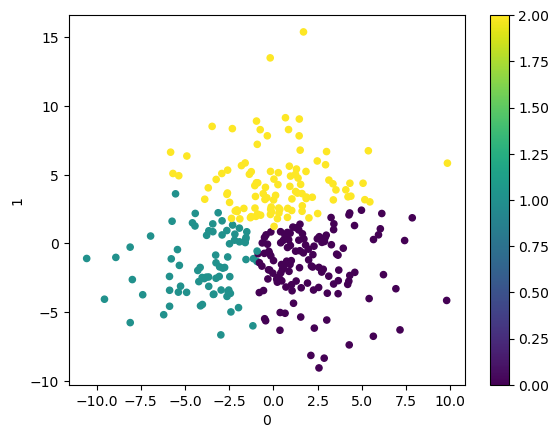

In [196]:
df = pd.DataFrame(X)
df['cluster'] = km.pred(X)
df.plot.scatter(x = 0, y = 1, c = df['cluster'], cmap="viridis")
map_clusters(means, km.centers, km.pred(X))

<Axes: xlabel='0', ylabel='1'>

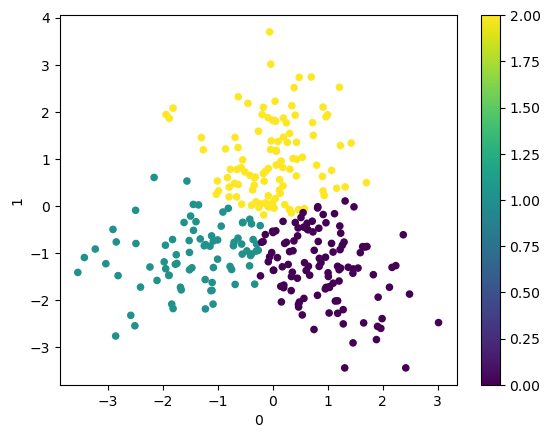